<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add csv files to a pandas dataframe

Run the below cell and if there are any file names that don't exist in the folder, it will print the file name. It's recommended to remove the rows that has the file name that doesn't exist in the folder. You can do this by uncommenting the last line in the below cell.

In [5]:
import pandas as pd
import os
from pathlib import Path
from tqdm.notebook import tqdm

file_paths = [file_path for file_path in list(Path('./tibetan-dataset/transcript/').iterdir())
                  if file_path.suffix == '.csv']
file_paths = file_paths[:2]

dfs = []

for file_path in tqdm(file_paths):
    batch_name = file_path.name.removesuffix('.csv')
    df = pd.read_csv(str(file_path), sep=',')
    df['batch_name'] = batch_name
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# change the column name line_image_id to file_name
df.rename(columns={'line_image_id': 'file_name'}, inplace=True)

# remove the rows that their image file does not exist
original_image_name = ''
thumbs_up = True
potential_missing_files = []
print('started')
for row in tqdm(df.iterrows(), total=df.shape[0]):
    file_name = row[1]['file_name']
    this_original_image_name = file_name.split('_')[0]
    if this_original_image_name != original_image_name:
        original_image_name = this_original_image_name
        batch_name = row[1]['batch_name']
        if not os.path.isfile('./tibetan-dataset/train/' + batch_name + '/' + file_name):
            thumbs_up = False
            potential_missing_files.append(file_name)
        else:
            thumbs_up = True
    else:
        if not thumbs_up:
            potential_missing_files.append(file_name)

df = df[~df['file_name'].isin(potential_missing_files)]

print("Removed rows with missing image files.")

We split up the data into training + testing, using sklearn's `train_test_split` function.

In [6]:
# check if a specific file name exists in df['file_name']
df['file_name'].str.contains('20-1-59b_line_9874_3.jpg').any()

False

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

In [8]:
import torch
from torch.utils.data import Dataset


class TibetanImageLinePairDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=512):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        folder_name = self.df['batch_name'][idx] + '/'
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + folder_name + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [9]:
encode, decode = "google/vit-base-patch16-224-in21k", "sangjeedondrub/tibetan-roberta-base"

Let's initialize the training and evaluation datasets:

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator()

In [10]:
from transformers import TrOCRProcessor, ViTImageProcessor, RobertaTokenizer

feature_extractor=ViTImageProcessor.from_pretrained(encode)
tokenizer = RobertaTokenizer.from_pretrained(decode)
print(tokenizer.vocab_size)
processor = TrOCRProcessor(image_processor=feature_extractor, tokenizer=tokenizer)
train_dataset = TibetanImageLinePairDataset(root_dir='./tibetan-dataset/train/',
                                            df=train_df[:len(train_df)],
                                            processor=processor)
eval_dataset = TibetanImageLinePairDataset(root_dir='./tibetan-dataset/train/',
                                           df=test_df[:len(test_df)],
                                           processor=processor)

22869


In [11]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 2999980
Number of validation examples: 749995


Let's verify an example from the training dataset:

In [12]:
from PIL import Image
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([512])


We can also check the original image and decode the labels:

In [13]:
train_df['file_name'][0]

'I4PD50100439_4.tif'

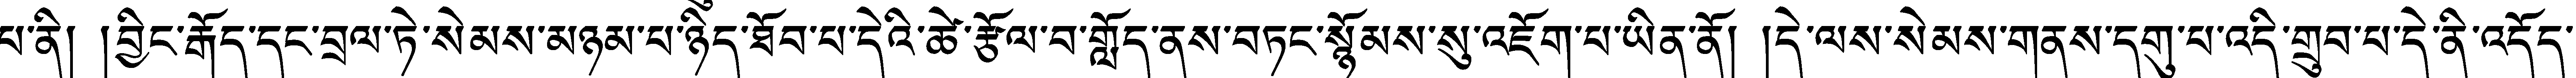

In [14]:
image = Image.open(train_dataset.root_dir + train_df['batch_name'][0] + '/' + train_df['file_name'][0]).convert("RGB")
image

In [15]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

པ་ནི། །བྱིང་རྒོད་དང་བྲལ་ཏེ་སེམས་མཉམ་པ་ཉིད་ཐོབ་པ་དེའི་ཚེ་རྩོལ་བ་གློད་ནས་བཏང་སྙོམས་སུ་འཇོག་པ་ཡིན་ནོ། །དེ་ལས་སེམས་གནས་དགུ་པ་འདི་གྲུབ་པ་དེ་ནི་འདོད་


Let's create corresponding dataloaders:

## Prepare data

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [16]:

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [17]:
use_existing_model = False
date = None

In [18]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if use_existing_model:
    if date is not None:
        model = VisionEncoderDecoderModel.from_pretrained(f"best_model_{date}")
    else:
        model = VisionEncoderDecoderModel.from_pretrained("test")
else:
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encode, decode)

assert model.config.decoder.is_decoder is True
assert model.config.decoder.add_cross_attention is True

cuda


Some weights of RobertaForCausalLM were not initialized from the model checkpoint at sangjeedondrub/tibetan-roberta-base and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.0.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.self.value.bias', 'roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.1.crossattention.output.dense.bias', 'roberta.encoder.layer.1.crossattention.output.dense.weight

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [19]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 512
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4


We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [20]:
import evaluate

cer_metric = evaluate.load("cer")

C:\Users\301212298\AppData\Local\Temp\ipykernel_23048\910432076.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
C:\Users\301212298\AppData\Local\pypoetry\Cache\virtualenvs\trocr-tibetan-fine-tuning-OTNbRY7o-py3.10\lib\site-packages\datasets\load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [21]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [22]:
from transformers import AdamW
from tqdm.notebook import tqdm
import datetime

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
best_cer = 10.0
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

for epoch in range(10):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      accelerator.backward(loss)
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):\
       # run batch generation
       outputs = model.generate(batch["pixel_values"])
       # compute metrics
       cer = compute_cer(pred_ids=accelerator.gather(outputs), label_ids=accelerator.gather(batch["labels"]))
       valid_cer += cer 

   current_cer = valid_cer / len(eval_dataloader)
   print("Validation CER:", current_cer)
   if current_cer < best_cer:
       print('Updating the best model')
       best_cer = current_cer
       model.save_pretrained(f"best_model_{date}")
       torch.save(optimizer.state_dict(), f"best_model_optimizer_{date}.pt")
   

model.save_pretrained(f"test_{date}")

  0%|          | 0/749995 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


KeyboardInterrupt: 

In [ ]:
import os
from accelerate.utils import write_basic_config
write_basic_config() # Write a config file
os._exit(00) # Restart the notebook

In [ ]:
file_paths = [file_path for file_path in list(Path('./tibetan-dataset/transcript/').iterdir())
                  if file_path.suffix == '.csv']
file_paths = file_paths[:2]

dfs = []

for file_path in tqdm(file_paths, disable=not accelerator.is_local_main_process):
    batch_name = file_path.name.removesuffix('.csv')
    df = pd.read_csv(str(file_path), sep=',')
    df['batch_name'] = batch_name
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# change the column name line_image_id to file_name
df.rename(columns={'line_image_id': 'file_name'}, inplace=True)

# remove the rows that their image file does not exist
original_image_name = ''
thumbs_up = True
potential_missing_files = []
print('started')
for row in tqdm(df.iterrows(), disable=not accelerator.is_local_main_process):
    file_name = row[1]['file_name']
    this_original_image_name = file_name.split('_')[0]
    if this_original_image_name != original_image_name:
        original_image_name = this_original_image_name
        batch_name = row[1]['batch_name']
        if not os.path.isfile('./tibetan-dataset/train/' + batch_name + '/' + file_name):
            thumbs_up = False
            potential_missing_files.append(file_name)
        else:
            thumbs_up = True
    else:
        if not thumbs_up:
            potential_missing_files.append(file_name)

df = df[~df['file_name'].isin(potential_missing_files)]

In [ ]:
from sklearn.model_selection import train_test_split
def get_dataloaders(batch_size):
    
    # split the data into training + testing
    train_df, test_df = train_test_split(df, test_size=0.2)
    # we reset the indices to start from zero
    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    
    # Create Dataset and DataLoader
    encode, decode = "google/vit-base-patch16-224-in21k", "sangjeedondrub/tibetan-roberta-base"
    
    feature_extractor=ViTImageProcessor.from_pretrained(encode)
    tokenizer = RobertaTokenizer.from_pretrained(decode)
    print(tokenizer.vocab_size)
    processor = TrOCRProcessor(image_processor=feature_extractor, tokenizer=tokenizer)
    train_dataset = TibetanImageLinePairDataset(root_dir='./tibetan-dataset/train/',
                                                df=train_df[:len(train_df)],
                                                processor=processor)
    eval_dataset = TibetanImageLinePairDataset(root_dir='./tibetan-dataset/train/',
                                               df=test_df[:len(test_df)],
                                               processor=processor)
    
    labels = encoding['labels']
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.decode(labels, skip_special_tokens=True)
    print(label_str)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size)
    
    
    return train_dataloader, eval_dataloader
    
    

In [ ]:
batch_size = 8
learning_rate = 5e-5
seed = 42
mixed_precision = "fp16"

In [ ]:
from accelerate import Accelerator, ProjectConfiguration
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split    
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from accelerate.utils import set_seed

def training_function():
    set_seed(seed)
    config = ProjectConfiguration(project_dir="./project", logging_dir="./logging")
    accelerator = Accelerator(log_with="tensorboard", project_config=config, mixed_precision=mixed_precision)
    
    train_dataloader, eval_dataloader = get_dataloaders(batch_size)
    
    
    from transformers import VisionEncoderDecoderModel
    import torch
    
    device = accelerator.device
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encode, decode)
    model.to(device)
    
    # set special tokens used for creating the decoder_input_ids from the labels
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    # make sure vocab size is set correctly
    model.config.vocab_size = model.config.decoder.vocab_size
    
    # set beam search parameters
    model.config.eos_token_id = processor.tokenizer.sep_token_id
    model.config.max_length = 512
    model.config.early_stopping = True
    model.config.no_repeat_ngram_size = 3
    model.config.length_penalty = 2.0
    model.config.num_beams = 4
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    best_cer = 10.0
    date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )
    
    for epoch in range(10):  # loop over the dataset multiple times
       # train
       model.train()
       for batch in tqdm(train_dataloader, disable=not accelerator.is_local_main_process):
          # get the inputs
    
          # forward + backward + optimize
          outputs = model(**batch)
          loss = outputs.loss
          accelerator.backward(loss)
          optimizer.step()
          optimizer.zero_grad()
    
       accelerator.wait_for_everyone()

       # evaluate
       model.eval()
       valid_cer = 0.0
       with torch.no_grad():
         for batch in tqdm(eval_dataloader, disable=not accelerator.is_local_main_process):
           # run batch generation
           outputs = model.generate(batch["pixel_values"])
           # compute metrics
           cer = compute_cer(pred_ids=accelerator.gather(outputs), label_ids=accelerator.gather(batch["labels"]))
           valid_cer += cer 
        
       accelerator.wait_for_everyone()

       current_cer = valid_cer / len(eval_dataloader)
       accelerator.print(f"Validation CER: {current_cer}")
       if accelerator.is_main_process and current_cer < best_cer:
           accelerator.save_state()
       
    
    model.save_pretrained(f"test_{date}")
    

In [ ]:
from accelerate import notebook_launcher
args = ()
notebook_launcher(training_function, args, num_processes=2)

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.